In [1]:
"""
source: https://github.com/LauraGomezNavarro/OceanParcels_Lyapunov/blob/main/code/FTLE_func_test.py
Author: Main code by Laura Gomez Navarro adapted by Darshika Manral
"""
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import xarray as xr
import numpy.linalg as LA
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from tqdm import tqdm
from scipy import stats
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scalebar import scale_bar

In [2]:
model_mask_file = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values

In [3]:
home_folder = "/nethome/manra003/analysis/dispersion/simulations/"
output_folder = '/nethome/manra003/analysis/dispersion/outputs/ftle/'

mon_num=6
mon_name ='June'
year=2017
mode= '2D'

asc_order='Fwd'

ds = xr.open_zarr(home_folder + '{0}/{1}/Benguela_{0}_1ov32_641x_321yres_{1}-{2}_5z_100days.zarr'.format(mode, year, str(mon_num).zfill(2)))

In [4]:
def ftle_brunton_2009(J, Td):  # http://cwrowley.princeton.edu/papers/BruntonChaos09.pdf
    D = np.dot(np.transpose(J), J)  # Cauchy–Green strain tensor
    lamda = LA.eigvals(D)
    lam_max = max(lamda)
    ftle = (1 / Td) * np.log(np.sqrt(lam_max))
    return ftle


def dist_pairs_km(inlon1, inlon2, inlat1, inlat2):
    """
    source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

    """
    # approximate radius of earth in km
    R = 6373.0

    lon1 = radians(inlon1)
    lat1 = radians(inlat1)
    lon2 = radians(inlon2)
    lat2 = radians(inlat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [5]:
def reshape_locations(loc, mask):
    reshaped_array = np.empty((mask.shape))  # Create an empty 2D array
    reshaped_array[:]=np.NAN
    
    # Iterate through the mask and assign locations to reshaped array
    index = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j]:
                reshaped_array[i][j] = loc[index]
                index += 1
    
    return reshaped_array

In [6]:
Td=30
mask_ds=np.load('/nethome/manra003/atlanteco_plankton_plastic_nutrients_dispersion/data/Benguela_cropped_boolmask_1ov32_641x_321ygrid.npz') #129x65
mask=mask_ds['mask']
out_index = Td # output everyday

# initial position
x0 = reshape_locations(ds['lon'][:, 0].values, mask)
y0 = reshape_locations(ds['lat'][:, 0].values, mask)

# final position
x1 = reshape_locations(ds['lon'][:, out_index].values, mask)
y1 = reshape_locations(ds['lat'][:, out_index].values, mask)

H = x0.shape[0]
L = x1.shape[1]

FTLE_f = np.ones_like(np.asarray(x0))
FTLE_f[:,:] = np.NaN

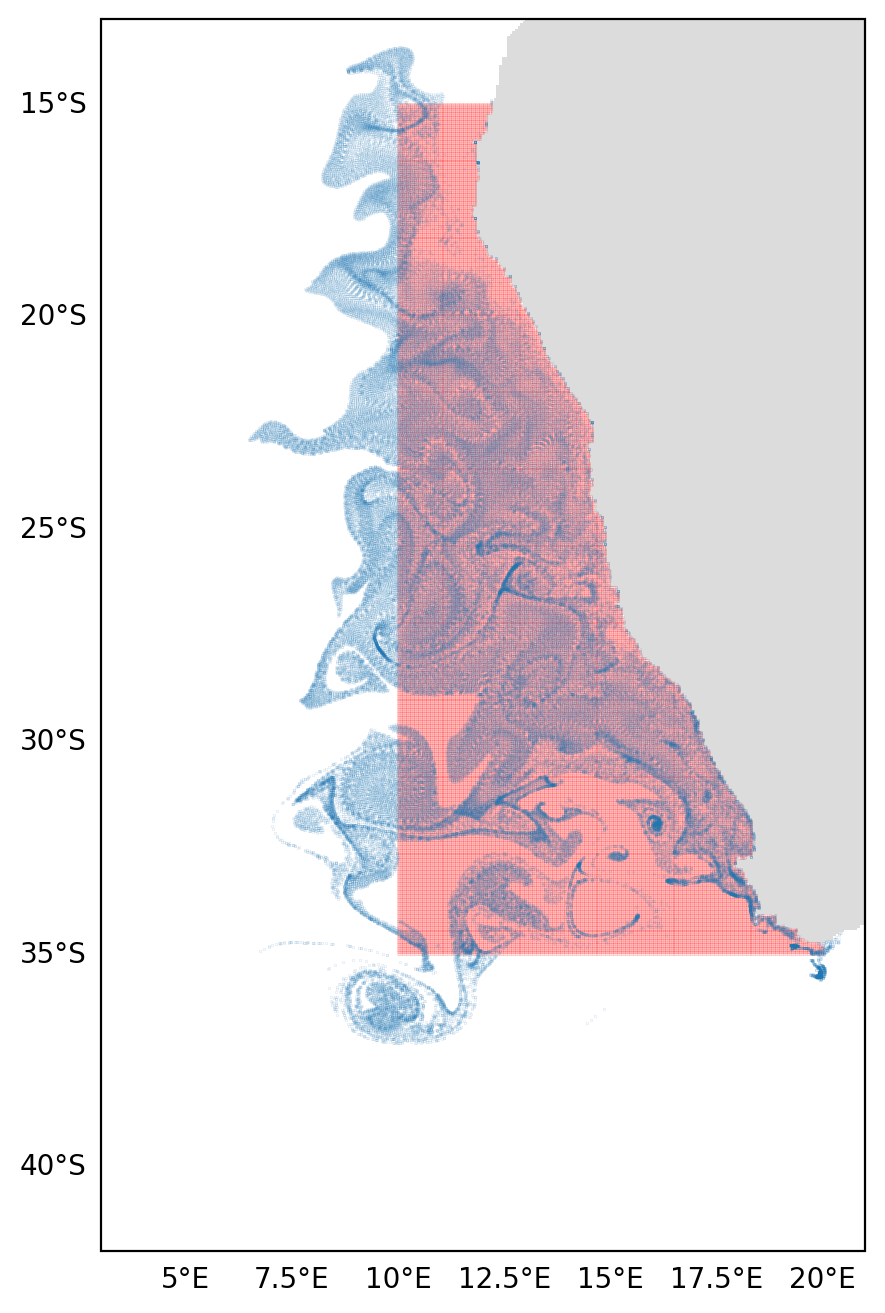

In [7]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}

colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(3,21)
ax.set_ylim(-42,-13)
# ax.set_xlim(16.5,18.5)
# ax.set_ylim(-32.5,-29.5)
ax.scatter(x0, y0, s=0.001, c='red')
ax.scatter(x1, y1, s=0.001)

plt.show()

In [8]:
J = np.empty([2, 2], float)

# 1, H-1 --> to ignore bordersx for now
for i in tqdm(range(1, H - 1)):  # 0, H-2
    for j in range(1, L - 1):  # 0, L-2
        # pool = multiprocessing.Pool()
        # pool = multiprocessing.Pool(processes=8)
        
        J [:,:] = np.NaN
        ls = np.array((x0[i, j], y0[i, j], 
                    x0[i - 1, j], y0[i - 1, j], 
                    x0[i, j - 1], y0[i, j - 1],
                    x0[i, j + 1], y0[i, j + 1],
                    x0[i + 1, j], y0[i + 1, j],
                    x1[i, j], y1[i, j], 
                    x1[i - 1, j], y1[i - 1, j], 
                    x1[i, j - 1], y1[i, j - 1],
                    x1[i, j + 1], y1[i, j + 1],
                    x1[i + 1, j], y1[i + 1, j]))
        if np.isnan(ls).any():
            continue

        J[0][0] = dist_pairs_km(x1[i, j], x1[i - 1, j], y1[i, j], y1[i - 1, j]) / dist_pairs_km(x0[i, j], x0[i - 1, j],
                                                                                                y0[i, j], y0[i - 1, j])
        J[0][1] = dist_pairs_km(x1[i, j], x1[i, j - 1], y1[i, j], y1[i, j - 1]) / dist_pairs_km(x0[i, j], x0[i, j - 1],
                                                                                                y0[i, j], y0[i, j - 1])
        J[1][0] = dist_pairs_km(x1[i, j], x1[i, j + 1], y1[i, j], y1[i, j + 1]) / dist_pairs_km(x0[i, j], x0[i, j + 1],
                                                                                                y0[i, j], y0[i, j + 1])
        J[1][1] = dist_pairs_km(x1[i, j], x1[i + 1, j], y1[i, j], y1[i + 1, j]) / dist_pairs_km(x0[i, j], x0[i + 1, j],
                                                                                                y0[i, j], y0[i + 1, j])
        f_value = ftle_brunton_2009(J, Td)
        FTLE_f[i][j] = f_value
print(np.nanmin(FTLE_f), np.nanmax(FTLE_f))


100%|██████████| 639/639 [00:06<00:00, 99.14it/s] 

-0.029548606679862293 0.19495989438726966


In [9]:
#Export the FTLE to output file
savename = output_folder + 'ftle_{3}d_Benguela_{0}_1ov32_641x_321yres_{1}-{2}_5z_100days.npz'.format(mode, year, str(mon_num).zfill(2),Td)
np.savez(savename, FTLE_f=FTLE_f)

In [10]:
savename = output_folder + 'ftle_{3}d_Benguela_{0}_1ov32_641x_321yres_{1}-{2}_5z_100days.npz'.format(mode, year, str(mon_num).zfill(2), Td)

ftle_ds=np.load(savename)
FTLE_f=ftle_ds['FTLE_f']

In [11]:
# FTLE_f[FTLE_f<0]=np.NaN

def convert_ftle_dataset(FTLE_f):
    x0 = reshape_locations(ds['lon'][:, 0].values, mask)
    y0 = reshape_locations(ds['lat'][:, 0].values, mask)
    f= FTLE_f

    modified_ds = xr.Dataset(
        data_vars=dict(
            FTLE_f=(["x", "y"], f)
        ),
        coords=dict(
            lon=(["x", "y"], x0),
            lat=(["x", "y"], y0)
        ),
        attrs=dict(description="FTLE field"),
    )
    return modified_ds
def crop_dataset(modified_ds):
    left_lon = 10
    right_lon = 20
    top_lat = -15
    bottom_lat = -35
    ds_cropped = modified_ds.where((modified_ds.lat>bottom_lat) & (modified_ds.lat<top_lat) & (modified_ds.lon>left_lon) & (modified_ds.lon<right_lon), drop=True)
    return ds_cropped

ds_1 = convert_ftle_dataset(FTLE_f)
cropped_ds_1 = crop_dataset(ds_1)
FTLE_1=cropped_ds_1['FTLE_f']
print(np.nanmin(FTLE_1), np.nanmax(FTLE_1))

-0.029548606679862293 0.19495989438726966


In [ ]:
custom_size, ticks_size = 8,8
min_lat, max_lat = -35, -15
min_lon, max_lon = 10, 20
pre_text = "FTLE- {0}: Austral summer {1}".format(mode,year)
dpi=300

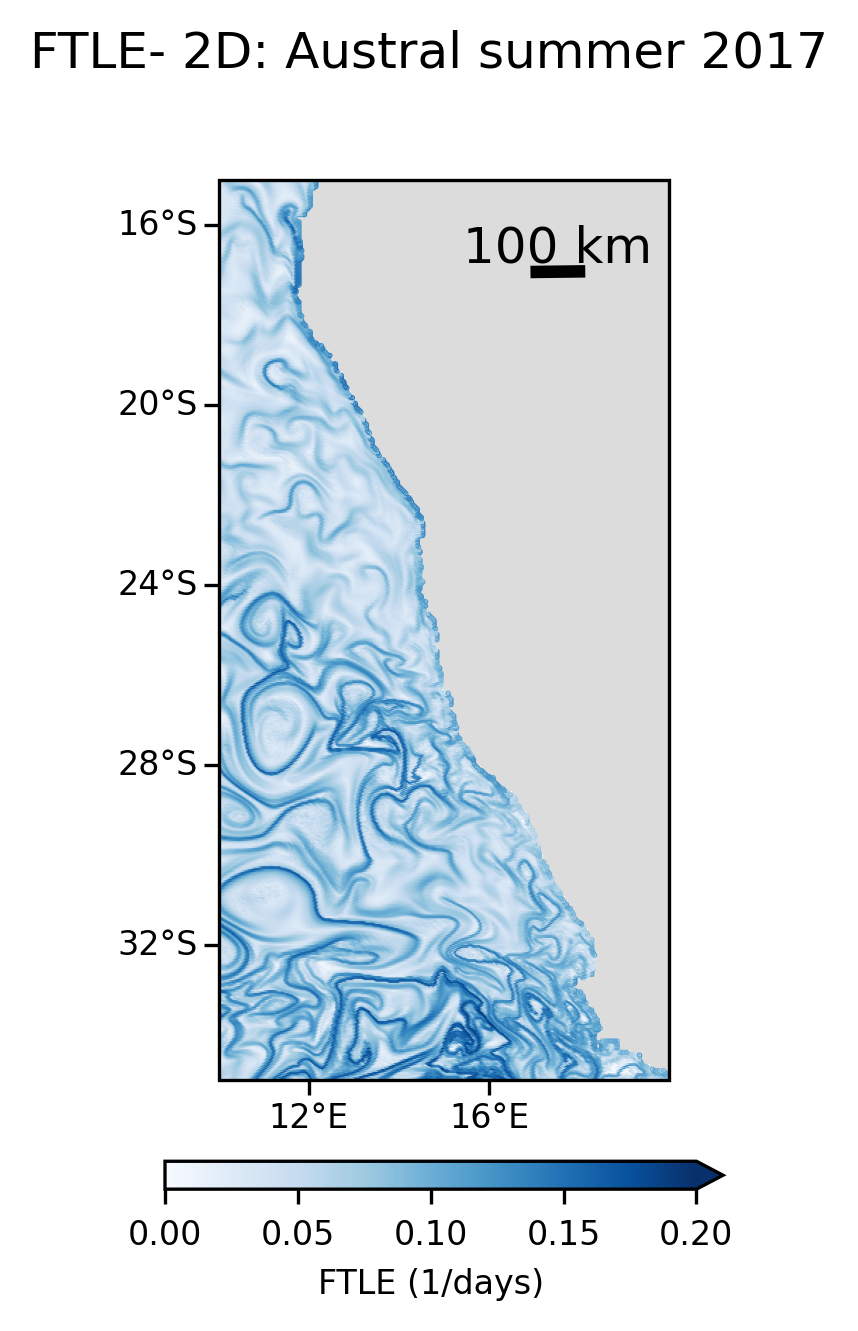

In [20]:
custom_size=8
ticks_size=8
fig = plt.figure(figsize=(4,5), dpi=300)
fig.suptitle(pre_text)
ax = plt.axes(projection=ccrs.PlateCarree())
x_ticks=np.arange(12,20,4)
y_ticks=np.arange(-36,-14,4)
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.xlocator = mticker.FixedLocator(x_ticks)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylines = False
gl.ylocator = mticker.FixedLocator(y_ticks)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': ticks_size, 'color': 'k'}
gl.ylabel_style = {'size': ticks_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.tick_params(axis='both',labelbottom=False, labeltop=False, labelleft=False, labelright=False, labelsize=custom_size)
# ax.add_feature(cfeature.COASTLINE, edgecolor='gray')

im= ax.scatter(cropped_ds_1['lon'], cropped_ds_1['lat'], c=FTLE_1, cmap='Blues', s=0.05, vmin=0, vmax=0.2) #, norm=colors.LogNorm(vmax=0.4))
cbar=fig.colorbar(im, ax=ax, extend='max', orientation='horizontal', shrink=0.6, pad=0.07)
cbar.set_label(label='FTLE (1/days)', size=custom_size)
cbar.ax.tick_params(labelsize=custom_size)

scale_bar(ax, 100, location=(0.75, 0.9))
plt.savefig(output_folder + 'plots/ftle_{3}d_Benguela_{0}_1ov32_641x_321yres_{1}-{2}_5z_100days.png'.format(mode, year, str(mon_num).zfill(2), Td))


DescribeResult(nobs=102741, minmax=(masked_array(data=-0.02954861,
             mask=False,
       fill_value=1e+20), masked_array(data=0.19495989,
             mask=False,
       fill_value=1e+20)), mean=0.07119937021508976, variance=0.0011417448656940341, skewness=masked_array(data=0.88069539,
             mask=False,
       fill_value=1e+20), kurtosis=0.2889643738496255)


(array([8.0000e+00, 2.6000e+01, 3.1800e+02, 5.6750e+03, 1.9318e+04,
        2.1262e+04, 1.7747e+04, 1.2781e+04, 8.6450e+03, 6.2750e+03,
        4.5480e+03, 2.9070e+03, 2.1600e+03, 9.1000e+02, 1.6100e+02]),
 array([-0.02954861, -0.01458137,  0.00038586,  0.01535309,  0.03032033,
         0.04528756,  0.06025479,  0.07522203,  0.09018926,  0.10515649,
         0.12012373,  0.13509096,  0.15005819,  0.16502543,  0.17999266,
         0.19495989]),
 <BarContainer object of 15 artists>)

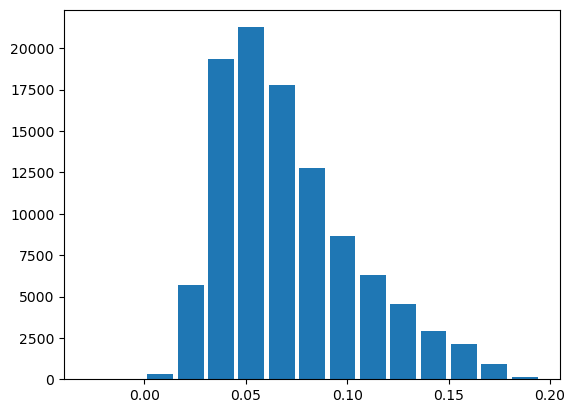

In [14]:
print(stats.describe(cropped_ds_1['FTLE_f'], axis= None, nan_policy='omit'))

plt.hist(cropped_ds_1['FTLE_f'].values.ravel(), bins=15, rwidth=0.85)

In [21]:
np.count_nonzero(np.where(FTLE_1<0))

68